# Initial attempt to learn from SF data

We use only basic algorithms

In [59]:
import sys
import os

import numpy as np
import pandas as pd
import sqlite3
from rdkit import Chem
from rdkit.Chem.Descriptors import rdMolDescriptors
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import cm

sys.path.insert(0, os.path.abspath('../..'))

from src.definitions import DB_PATH
from src.util.db_utils import MyDatabaseConnection

In [60]:
db = MyDatabaseConnection()  # we will use this for various simple queries

In [61]:
con = sqlite3.connect(DB_PATH)
df_full = pd.read_sql('SELECT * FROM experiments', con, index_col='id', coerce_float=False)
con.close()
print(f'Number of reactions (in total): {len(df_full)}')

Number of reactions (in total): 58664


In [62]:
# select experiment numbers for further analysis
start_exp_nr = 4  # kick out invalid experiments (SOP changed after exp3)
end_exp_nr = 29  # (inclusive)

df_full = df_full.loc[df_full['exp_nr'].between(start_exp_nr, end_exp_nr)]  
                      
print(f'Number of reactions considered here: {len(df_full)}')

Number of reactions considered here: 49920


In [63]:
# doublecheck that there are no "empty" experiments where results are missing
df_full[df_full["product_A_lcms_ratio"].isna()]

,exp_nr,plate_nr,well,lab_journal_number,synthesis_date_unixepoch,initiator,monomer,terminator,initiator_long,monomer_long,...,product_A_smiles,product_B_smiles,product_C_smiles,product_D_smiles,product_E_smiles,product_F_smiles,product_G_smiles,product_H_smiles,vl_id,valid
id,,,,,,,,,,,,,,,,,,,,,


In [69]:
df_full.loc[~df_full["valid"].str.contains("ERROR", na=False), "valid"].value_counts().index

Index(['WARNING: multiple peaks for product A (2)',
       'WARNING: multiple peaks for product A (3)', 'heating failure',
       'WARNING: multiple peaks for product A (4)',
       'too many peaks for product A (2)', 'too many peaks for product A (3)',
       'WARNING: IS response differs >50% from mean',
       'too many peaks for product A (4)',
       'too many peaks for IS (2); WARNING: IS response differs >50% from mean',
       'I/M transfer error; Dilution survey low volume',
       'too many peaks for product A (5)',
       'bad LCMS M54; too many peaks for product A (3)', 'bad LCMS M54',
       'I/M transfer error; Dilution transfer error; Dilution survey low volume',
       'WARNING: multiple peaks for product A (2); WARNING: IS response differs >50% from mean',
       'bad LCMS M54; too many peaks for product A (2)',
       'bad LCMS M54; too many peaks for product A (4)',
       'too many peaks for IS (2)',
       'precipitation I36; I/M transfer error; Dilution survey low

In [71]:
df_full["valid"].isna().value_counts()

True     39044
False     8212
Name: valid, dtype: int64

In [66]:
# remove everything that says ERROR
df_full = df_full.loc[~df_full["valid"].str.contains("ERROR", na=False)]
len(df_full)

47256

<Axes: ylabel='Frequency'>

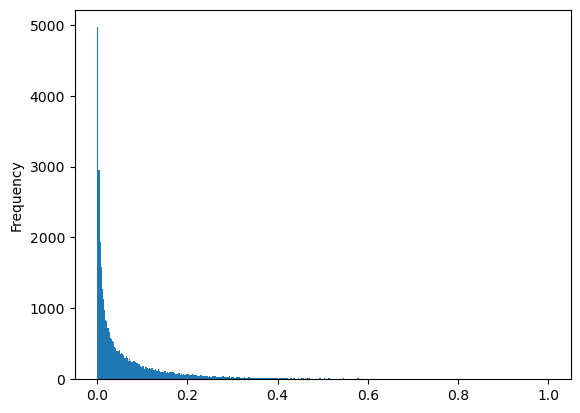

In [7]:
# plot everything with a value > 0
df_full.loc[df_full["product_A_lcms_ratio"].between(1e-10,1), "product_A_lcms_ratio"].plot.hist(bins=400)

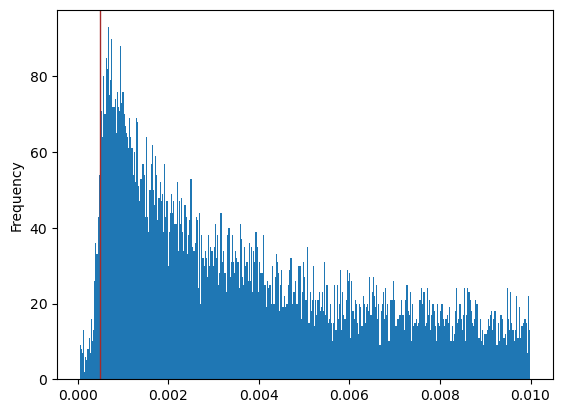

In [8]:
# plot only the region where response > 0, but <0.01 
df_full.loc[df_full["product_A_lcms_ratio"].between(1e-10,0.01), "product_A_lcms_ratio"].plot.hist(bins=400)
plt.axvline(5e-4, c="brown", linewidth=1)

In [9]:
# we exclude everything between 1e-10 and 5e-4 as it may well be noise.
# But we exclude it altogether and don't put it in the negative class
# To everything else we assign classes 0 (failure) and 1 (success)

df_full["product_A_outcome"] = np.nan
df_full.loc[df_full["product_A_lcms_ratio"] == 0, "product_A_outcome"] = 0
df_full.loc[df_full["product_A_lcms_ratio"] > 5e-4, "product_A_outcome"] = 1

In [10]:
df_full["product_A_outcome"].value_counts()

1.0    35213
0.0    11715
Name: product_A_outcome, dtype: int64

In [11]:
df_full["product_A_outcome"].isna().value_counts()

False    46928
True       328
Name: product_A_outcome, dtype: int64

In [12]:
descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())

get_descriptors = rdMolDescriptors.Properties(descriptor_names)

def smi_to_descriptors(smile):
    mol = Chem.MolFromSmiles(smile)
    descriptors = []
    if mol:
        descriptors = np.array(get_descriptors.ComputeProperties(mol))
    return descriptors

In [13]:
df_full['descriptors'] = df_full["product_A_smiles"].apply(smi_to_descriptors)

In [14]:
df_pred = df_full.dropna(subset=["descriptors", "product_A_outcome"])

In [15]:
# extract our data
X = np.stack(df_pred["descriptors"].values.tolist())
y = df_pred["product_A_outcome"].values

In [16]:
X.shape

(46928, 43)

In [17]:
y.shape

(46928,)

In [18]:
# train-test split (produce indices)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [18]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [19]:
# scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [20]:
# hparam search
val_scores = []
Cs = np.logspace(-3, 4, num=100)
for C in Cs:
    model = LogisticRegression(C=C, solver="newton-cholesky")
    model.fit(X_train, y_train)
    y_hat = model.predict(X_val)
    val_scores.append(accuracy_score(y_val, y_hat))

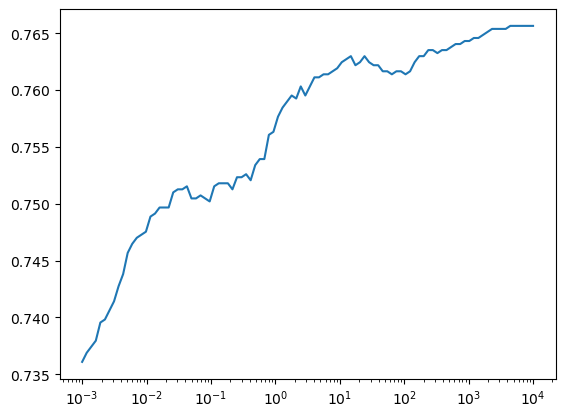

In [21]:
# show hparam search results
plt.plot(Cs, val_scores)
plt.xscale("log")
plt.show()

In [22]:
# best C
best_C = Cs[np.argmax(val_scores)]
print(best_C)

4430.621457583878


In [23]:
# refit best model and evaluate on test set
model = LogisticRegression(C=best_C, solver="newton-cholesky")
model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
y_hat = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_hat)}")
print(f"Balanced Accuracy: {np.sqrt(balanced_accuracy_score(y_test, y_hat))}")
print(f"F1-score: {np.sqrt(f1_score(y_test, y_hat))}")

Accuracy: 0.7851054762412103
Balanced Accuracy: 0.7714923071959282
F1-score: 0.9337536291491403


In [24]:
y_test.mean()

0.7497336458555295

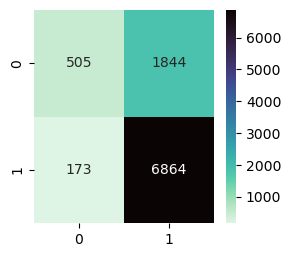

In [25]:
plt.figure(figsize=(3,2.67))
sns.heatmap(confusion_matrix(y_test, y_hat), annot=True, fmt="01", cmap=sns.color_palette("mako_r", as_cmap=True))
plt.tight_layout()
plt.savefig("confusion_matrix_LogReg_props.png", dpi=300)

In [26]:
# get highest coefficients
highest_coefs = np.argsort(np.abs(model.coef_.flatten()))[::-1]

In [27]:
# show most extreme coefficients with their names
for idx in highest_coefs[:5]:
    print(descriptor_names[idx])
    print(model.coef_.flatten()[idx])

amw
-80.28762484236597
exactmw
79.99165378091763
NumHeavyAtoms
-67.85207015824408
kappa1
25.719421146851428
labuteASA
21.36291166520083


In [28]:
# helper function
def iterable_to_nested_list(list_to_break_up, inner_len, pad_last=False, pad_value=None):
    """Break up list into nested lists of given length"""
    # invert list for fast pop()
    list_tmp = list(reversed(list_to_break_up))

    outer_list = []
    while len(list_tmp) > 0:
        inner_list = []
        while len(inner_list) < inner_len:
            if len(list_tmp) == 0:
                if pad_last:
                    while len(inner_list) < inner_len:
                        inner_list.append(pad_value)
                break
            inner_list.append(list_tmp.pop())
        outer_list.append(inner_list)
    return outer_list

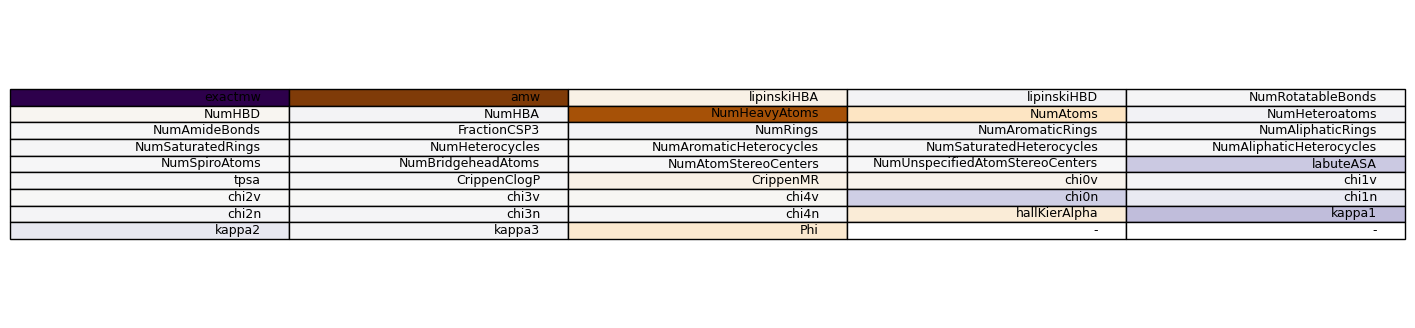

In [29]:
# show most extreme descriptors
fig, ax = plt.subplots(figsize=(18,4))
ax.axis('tight')
ax.axis('off')

norm = plt.Normalize()
colors = iterable_to_nested_list(cm.PuOr(norm(model.coef_.flatten())), 5,True,  np.array([1.,1.,1.,1.]))

ax.table(cellText = iterable_to_nested_list(descriptor_names, 5, True, "-"), cellColours=colors, loc='center')
plt.show()

In [30]:
# let's train a different model instead: OHE of reactants + FFN
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
df_OHE = df_pred[["initiator", "monomer", "terminator"]]
df_OHE

,initiator,monomer,terminator
id,,,
10578,I67,M20,T25
10579,I67,M20,T39
10580,I67,M20,T30
10581,I67,M20,T34
10582,I67,M20,T17
...,...,...,...
85517,I33,M22,T31
85518,I33,M22,T40
85519,I33,M22,T20


In [31]:
X_train, X_test, y_train, y_test = train_test_split(df_OHE.values, y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [32]:
X_train_OHE = ohe.fit_transform(X_train)
X_val_OHE = ohe.transform(X_val)
X_test_OHE = ohe.transform(X_test)

In [33]:
import torch


In [34]:
class FFN(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.W_i = torch.nn.Linear(input_size, 600, bias=True)
        self.W_h = torch.nn.Linear(600, 400, bias=True)
        self.W_o = torch.nn.Linear(400, 1, bias=False)
        self.activation = torch.nn.ReLU()
        
    def forward(self, x):
        return self.W_o(self.activation(self.W_h(self.activation(self.W_i(x)))))

In [35]:
class SFDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [36]:
model = FFN(182)

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [38]:
loss_fn = torch.nn.BCEWithLogitsLoss()

In [39]:
dataset_train = SFDataset(X_train_OHE, y_train)
dataset_val = SFDataset(X_val_OHE, y_val)
dataset_test = SFDataset(X_test_OHE, y_test)

In [40]:
training_loader = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)

In [41]:
validation_loader = torch.utils.data.DataLoader(dataset_val, batch_size=32, shuffle=False)

In [42]:
next(iter(training_loader))

[tensor([[0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]

In [43]:
torch.tensor([0,1]).reshape(-1,1).shape

torch.Size([2, 1])

In [44]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels.reshape(-1, 1))
        
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

        last_loss = running_loss / (i+1) # loss per batch
        #print('  batch {} loss: {}'.format(i + 1, last_loss))

    return last_loss


In [45]:
EPOCHS = 100

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels.reshape(-1,1))
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}'.format(epoch)
        torch.save(model.state_dict(), model_path)



EPOCH 1:
LOSS train 0.42146226264310604 valid 0.28241395950317383
EPOCH 2:
LOSS train 0.2743064952709458 valid 0.2654368281364441
EPOCH 3:
LOSS train 0.2561285863816738 valid 0.2582970857620239
EPOCH 4:
LOSS train 0.23887209722038472 valid 0.24895885586738586
EPOCH 5:
LOSS train 0.21776205210071622 valid 0.23731984198093414
EPOCH 6:
LOSS train 0.19283488572321156 valid 0.23033693432807922
EPOCH 7:
LOSS train 0.16651609899645503 valid 0.22344975173473358
EPOCH 8:
LOSS train 0.1418215679309585 valid 0.2192017138004303
EPOCH 9:
LOSS train 0.12033389923924749 valid 0.22596661746501923
EPOCH 10:
LOSS train 0.1012202577913801 valid 0.23012863099575043
EPOCH 11:
LOSS train 0.08602036930733557 valid 0.24627774953842163
EPOCH 12:
LOSS train 0.07139968856322494 valid 0.24925734102725983
EPOCH 13:
LOSS train 0.058893475902238576 valid 0.26074740290641785
EPOCH 14:
LOSS train 0.048352751167434635 valid 0.2771136164665222
EPOCH 15:
LOSS train 0.038436591541676814 valid 0.2877732217311859
EPOCH 16:


In [46]:
model_path

'model_7'

In [47]:
best_model = FFN(182)
best_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [48]:
best_model.eval()

with torch.no_grad():
    pred = torch.sigmoid(model(dataset_test.X))
    print(pred)
    predicted, actual = (pred > 0.5).float(), dataset_test.y
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

tensor([[2.6274e-10],
        [5.2079e-01],
        [1.9902e-09],
        ...,
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00]])
Predicted: "tensor([[0.],
        [1.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])", Actual: "tensor([0., 1., 0.,  ..., 1., 1., 1.])"


In [49]:
(pred > 0.5).count_nonzero()

tensor(8895)

In [50]:
accuracy_score(predicted, actual)

0.9076883736788272

In [51]:
dataset_test.y.count_nonzero()

tensor(8788)

In [52]:
confusion_matrix(predicted, actual)

array([[2349,  488],
       [ 595, 8300]])

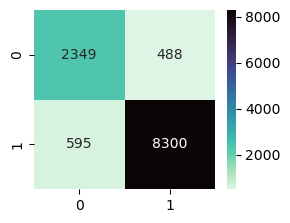

In [53]:
plt.figure(figsize=(3,2.33))
sns.heatmap(confusion_matrix(predicted, actual), annot=True, fmt="01", cmap=sns.color_palette("mako_r", as_cmap=True))
plt.tight_layout()
plt.savefig("confusion_matrix_FFN_OHE.png", dpi=300)

In [54]:
f1_score(predicted, actual)

0.9387547361872985

In [55]:
balanced_accuracy_score(predicted, actual)

0.8805478992269304

In [58]:
actual.mean()

tensor(0.7491)